In [3]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
import cv2
import sys
import os
import time
import json
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

In [4]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [5]:
# loading yolov11 model
model_yolo = YOLO("checkpoints/YOLO11/yolo11n.pt")

In [6]:
# loading sam2.1 model
model_info = {
    'tiny': ["configs/sam2.1/sam2.1_hiera_t.yaml", "sam2checkpoints/sam2.1_hiera_tiny.pt"],
    'small': ["configs/sam2.1/sam2.1_hiera_s.yaml", "checkpoints/sam2.1_hiera_small.pt"],
    'base+': ["configs/sam2.1/sam2.1_hiera_b+.yaml", "checkpoints/sam2.1_hiera_base_plus.pt"],
    'large': ["configs/sam2.1/sam2.1_hiera_l.yaml", "checkpoints/sam2.1_hiera_large.pt"]
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_name = 'base+'
config_yaml, model_checkpoint = model_info[model_name] 
sam2_model = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
predictor = SAM2ImagePredictor(sam2_model)

In [32]:
image_path = r"/mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_12/weti2_2024_11_12_12_57_m.jpg"


image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_12/weti2_2024_11_12_12_57_m.jpg: 384x640 33 cars, 1 truck, 25.7ms
Speed: 425.3ms preprocess, 25.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
masks.shape=(34, 1, 1080, 1920)


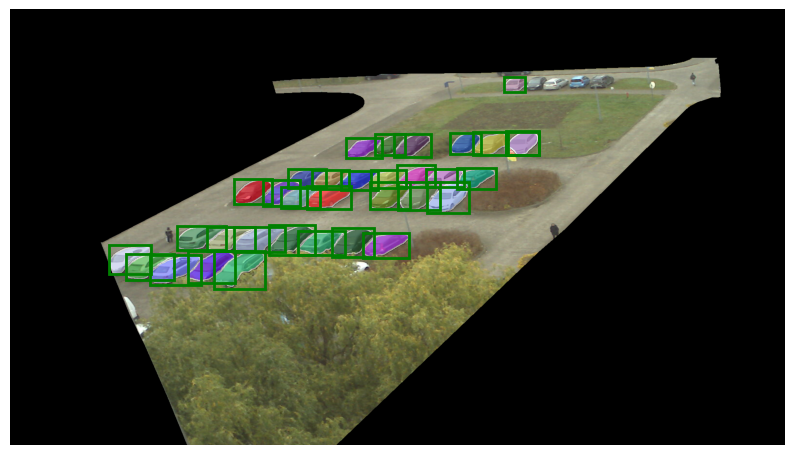

In [ ]:
results = model_yolo.predict(image_path, classes=[2, 3, 5, 7], conf=0.05)
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

input_boxes = np.array([bbox.data.cpu().numpy()[0][:4] for bbox in results[0].boxes])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

print(f"{masks.shape=}")

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)SS
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [34]:
input_boxes

array([[     735.38,      437.24,      844.84,      495.24],
       [     796.97,      542.43,       901.9,       613.7],
       [     890.46,       428.5,      991.33,      495.76],
       [     244.59,      584.64,      349.17,      655.74],
       [     346.28,      608.09,      472.28,      682.66],
       [     1032.8,      428.36,      1136.1,      503.63],
       [     441.22,      597.64,      557.39,       677.8],
       [     488.31,      540.34,      605.31,      598.39],
       [      626.3,      421.77,      717.77,      487.23],
       [     713.55,      549.64,      829.74,      608.47],
       [     873.12,      553.54,      988.72,      616.21],
       [     504.54,      598.37,      631.06,      692.58],
       [     555.62,      538.99,      680.07,      601.82],
       [     412.36,      535.96,      535.84,      595.83],
       [     641.97,      534.16,      755.09,      608.72],
       [      287.2,      605.51,      405.66,      669.92],
       [     671.51,    

In [31]:
masks[0].shape

(1, 1080, 1920)

### Segmentacja na całym zbiorze

In [1]:
from ultralytics import YOLO

import matplotlib.pyplot as plt
import cv2
import sys
import os
import time
import json
import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

In [2]:
def transform_to_polygons(data, mode="points"):
    polygons = []
    if mode == "points":
        polygons = [points2polygon(d) for d in data]
    elif mode == "corners":
        polygons = [corners2polygon(d) for d in data]
    elif mode == "mask":
        polygons = [mask2polygon(d) for d in data]
    return [p for p in polygons if p is not None]
    
def corners2polygon(corners):
    x1, y1, x2, y2 = corners
    points = [(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)]
    
    return Polygon(points)
        
def points2polygon(points):
    return Polygon(points)

def mask2polygon(mask):
    mask = np.array(mask).squeeze()
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    polygon = Polygon(shell=largest_contour.squeeze())
    
    if not polygon.is_valid:
        polygon = polygon.buffer(0)
    
    return polygon

def iou(polygon1, polygon2):
    if not polygon1.is_valid:
        polygon1 = polygon1.buffer(0)
    if not polygon2.is_valid:
        polygon2 = polygon2.buffer(0)
    union = polygon1.union(polygon2).area
    if union <= 0:
        return 0
    intersection = polygon1.intersection(polygon2).area
    return intersection / union

def build_similarity_matrix(objects_db, objects_pred):
    len_db, len_pred = len(objects_db), len(objects_pred)
    print(f"Matrix size: [{len_db}, {len_pred}]")
    similarity_matrix = np.zeros([len_db, len_pred])
    
    time_start = time.time()
    for x, obj_db in enumerate(objects_db):
        for y, obj_pred in enumerate(objects_pred):
            similarity_matrix[x, y] = iou(obj_db, obj_pred)
            print(f"Building similarity matrix: {x * len_pred + y + 1:>10}/{len_db*len_pred}", end='\r')
    time_end = time.time() - time_start
    print(f"Similarity matrix built in {time_end:.2f}s" + ' ' * 100)
    return similarity_matrix

def match_polygons(similarity_matrix):
    xs, ys = linear_sum_assignment(similarity_matrix, maximize=True)
    matching = [[x, y, similarity_matrix[x, y]] for x, y in zip(xs, ys) if similarity_matrix[x][y] > 0]
    return matching

def evaluate_segmentation(polygons_db, polygons_pred, matching, time, weather_info = [], model_info = []):
    results = {
        "weather": weather_info,
        "model": model_info,
        "time": time
    }
    num_db = len(polygons_db)
    num_pred = len(polygons_pred)
    num_matching = len(matching)

    results['ground_truth_objects'] = num_db
    results['segmented_objects'] = num_pred
    results['matched_objects'] = num_matching

    if num_pred != 0:
        results['precision'] = num_matching / num_pred
    else:
        results['precision'] = 0

    if num_db != 0:
        results['recall'] = num_matching / num_db
    else:
        results['recall'] = 0

    if results['precision'] + results['recall'] != 0:
        results['f1'] = 2 * results['precision'] * results['recall'] / (results['precision'] + results['recall'])
    else:
        results['precision'] = 0

    ious = []
    for x, y, _ in matching:
        ious.append(iou(polygons_db[x], polygons_pred[y]))

    if num_matching != 0:
        results['mean_iou'] = sum(ious) / num_matching
    else:
        results['mean_iou'] = 0

    return results

In [3]:
# loading yolov11 model
model_checkpoints_yolo = {
    "yolo11m": "checkpoints/YOLO11/yolo11m.pt",
    "yolo11n": "checkpoints/YOLO11/yolo11n.pt",
    "yolo11s": "checkpoints/YOLO11/yolo11s.pt",
    "yolo11l": "checkpoints/YOLO11/yolo11l.pt",
    "yolo11x": "checkpoints/YOLO11/yolo11x.pt"
}

model_name_yolo = 'yolo11x'

# loading sam2.1 model
model_info = {
    'tiny': ["configs/sam2.1/sam2.1_hiera_t.yaml", "sam2checkpoints/sam2.1_hiera_tiny.pt"],
    'small': ["configs/sam2.1/sam2.1_hiera_s.yaml", "checkpoints/sam2.1_hiera_small.pt"],
    'base+': ["configs/sam2.1/sam2.1_hiera_b+.yaml", "checkpoints/sam2.1_hiera_base_plus.pt"],
    'large': ["configs/sam2.1/sam2.1_hiera_l.yaml", "checkpoints/sam2.1_hiera_large.pt"]
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_name_sam2 = 'base+'

input_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_done'
output_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_14/dataset_results'

In [4]:
def segment_yolo_sam2(model_yolo, predictor, image_path, conf=0.5):
    results = model_yolo.predict(image_path, classes=[2, 3, 5, 7], conf=conf)
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)

    input_boxes = np.array([bbox.data.cpu().numpy()[0][:4] for bbox in results[0].boxes])
    
    if input_boxes.size == 0:
        return []

    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_boxes,
        multimask_output=False,
    )

    return masks

In [5]:
# for model_name in model_info.keys():
for conf in [0.01, 0.05, 0.1, 0.5]:
    model_yolo = YOLO(model_checkpoints_yolo[model_name_yolo])
    config_yaml, model_checkpoint = model_info[model_name_sam2] 
    model_sam2 = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
    predictor = SAM2ImagePredictor(model_sam2)

    output_dir_model = f"{output_dir}_{model_name_yolo}_{model_name_sam2}_conf{conf}"
    print(f"output_dir: {output_dir_model}")

    # fix directories
    if not os.path.exists(output_dir_model):
        os.makedirs(output_dir_model)

    # for image in dir
    for image_file in os.listdir(input_dir):
        data_pred = {
            'model': [model_name_sam2, model_name_yolo]
        }
        
        # skip non-images
        if not image_file.endswith(('jpg', 'png')):
            continue
        print(f"\nImage: {image_file}")
        # load image - handled inside segment function
        # image_bgr = cv2.imread(os.path.join(input_dir, image_file))
        # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        # measure time
        time_start = time.time()
        # generate masks
        masks = segment_yolo_sam2(model_yolo, predictor, os.path.join(input_dir, image_file), conf)
        time_end = time.time() - time_start

        # save results
        data_pred['time'] = time_end
        data_pred['objects'] = []
        for mask in masks:
            object_dict = {
                'segmentation': mask.tolist()
            }
            data_pred['objects'].append(object_dict)

        # load labeled data
        data_filename = '.'.join(image_file.replace('_m', '').split('.')[:-1]) + '.json'
        with open(os.path.join(input_dir, data_filename), 'r') as f:
            data_db = json.load(f)

        data_db['polygons'] = transform_to_polygons([obj['points'] for obj in data_db['objects']])
        data_pred['polygons'] = transform_to_polygons([obj['segmentation'] for obj in data_pred['objects']], 'mask')

        sm = build_similarity_matrix(data_db['polygons'], data_pred['polygons'])
        matching = match_polygons(sm)

        result_dict = evaluate_segmentation(data_db['polygons'], data_pred['polygons'], matching, data_pred['time'], data_db['weather'], ['sam2.1', model_name_sam2, model_name_yolo])
        result_dict['filename'] = '.'.join(image_file.split('.')[:-1])
        result_dict['model_params'] = f'{conf=}'

        json_path = os.path.join(output_dir_model, f"{'.'.join(image_file.split('.')[:-1])}.json")
        with open(json_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)

output_dir: /mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_14/dataset_results_yolo11x_base+_conf0.01

Image: weti1_2024_11_14_12_47.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_done/weti1_2024_11_14_12_47.jpg: 384x640 13 cars, 2 trucks, 193.9ms
Speed: 43.8ms preprocess, 193.9ms inference, 1380.1ms postprocess per image at shape (1, 3, 384, 640)


/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value 

Matrix size: [14, 15]
Similarity matrix built in 0.06s                                                                                                    

Image: weti1_2024_11_14_12_47_m.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_done/weti1_2024_11_14_12_47_m.jpg: 384x640 93 cars, 14 trucks, 173.1ms
Speed: 2.7ms preprocess, 173.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [14, 107]
Similarity matrix built in 0.13s                                                                                                    

Image: weti1_2024_11_14_12_57.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_done/weti1_2024_11_14_12_57.jpg: 384x640 13 cars, 2 trucks, 267.0ms
Speed: 20.2ms preprocess, 267.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [14, 15]
Similarity matrix built in 0.02s                                                                                                    

Image: weti1_20

In [6]:
input_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_05'
output_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_05/dataset_results'

# for model_name in model_info.keys():
for conf in [0.05]:
    model_yolo = YOLO(model_checkpoints_yolo[model_name_yolo])
    config_yaml, model_checkpoint = model_info[model_name_sam2] 
    model_sam2 = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
    predictor = SAM2ImagePredictor(model_sam2)

    output_dir_model = f"{output_dir}_{model_name_yolo}_{model_name_sam2}_conf{conf}"
    print(f"output_dir: {output_dir_model}")

    # fix directories
    if not os.path.exists(output_dir_model):
        os.makedirs(output_dir_model)

    # for image in dir
    for image_file in os.listdir(input_dir):
        data_pred = {
            'model': [model_name_sam2, model_name_yolo]
        }
        
        # skip non-images
        if not image_file.endswith(('jpg', 'png')):
            continue
        print(f"\nImage: {image_file}")
        # load image - handled inside segment function
        # image_bgr = cv2.imread(os.path.join(input_dir, image_file))
        # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        # measure time
        time_start = time.time()
        # generate masks
        masks = segment_yolo_sam2(model_yolo, predictor, os.path.join(input_dir, image_file), conf)
        time_end = time.time() - time_start

        # save results
        data_pred['time'] = time_end
        data_pred['objects'] = []
        for mask in masks:
            object_dict = {
                'segmentation': mask.tolist()
            }
            data_pred['objects'].append(object_dict)

        # load labeled data
        data_filename = '.'.join(image_file.replace('_m', '').split('.')[:-1]) + '.json'
        with open(os.path.join(input_dir, data_filename), 'r') as f:
            data_db = json.load(f)

        data_db['polygons'] = transform_to_polygons([obj['points'] for obj in data_db['objects']])
        data_pred['polygons'] = transform_to_polygons([obj['segmentation'] for obj in data_pred['objects']], 'mask')

        sm = build_similarity_matrix(data_db['polygons'], data_pred['polygons'])
        matching = match_polygons(sm)

        result_dict = evaluate_segmentation(data_db['polygons'], data_pred['polygons'], matching, data_pred['time'], data_db['weather'], ['sam2.1', model_name_sam2, model_name_yolo])
        result_dict['filename'] = '.'.join(image_file.split('.')[:-1])
        result_dict['model_params'] = f'{conf=}'

        json_path = os.path.join(output_dir_model, f"{'.'.join(image_file.split('.')[:-1])}.json")
        with open(json_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)

output_dir: /mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_05/dataset_results_yolo11x_base+_conf0.05

Image: weti1_2024_11_05_10_26.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_05/weti1_2024_11_05_10_26.jpg: 384x640 30 cars, 9 trucks, 27.1ms
Speed: 1.8ms preprocess, 27.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [13, 39]
Similarity matrix built in 0.04s                                                                                                    

Image: weti1_2024_11_05_10_26_m.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_05/weti1_2024_11_05_10_26_m.jpg: 384x640 8 cars, 4 trucks, 195.2ms
Speed: 3.1ms preprocess, 195.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [13, 12]
Similarity matrix built in 0.01s                                                                                                    

Image: weti1_2024_11_05_10_36.jpg

image 1/1 /mnt/c/Users/gtraw/P

In [7]:
input_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_12'
output_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_12/dataset_results'

# for model_name in model_info.keys():
for conf in [0.05]:
    model_yolo = YOLO(model_checkpoints_yolo[model_name_yolo])
    config_yaml, model_checkpoint = model_info[model_name_sam2] 
    model_sam2 = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
    predictor = SAM2ImagePredictor(model_sam2)

    output_dir_model = f"{output_dir}_{model_name_yolo}_{model_name_sam2}_conf{conf}"
    print(f"output_dir: {output_dir_model}")

    # fix directories
    if not os.path.exists(output_dir_model):
        os.makedirs(output_dir_model)

    # for image in dir
    for image_file in os.listdir(input_dir):
        data_pred = {
            'model': [model_name_sam2, model_name_yolo]
        }
        
        # skip non-images
        if not image_file.endswith(('jpg', 'png')):
            continue
        print(f"\nImage: {image_file}")
        # load image - handled inside segment function
        # image_bgr = cv2.imread(os.path.join(input_dir, image_file))
        # image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        # measure time
        time_start = time.time()
        # generate masks
        masks = segment_yolo_sam2(model_yolo, predictor, os.path.join(input_dir, image_file), conf)
        time_end = time.time() - time_start

        # save results
        data_pred['time'] = time_end
        data_pred['objects'] = []
        for mask in masks:
            object_dict = {
                'segmentation': mask.tolist()
            }
            data_pred['objects'].append(object_dict)

        # load labeled data
        data_filename = '.'.join(image_file.replace('_m', '').split('.')[:-1]) + '.json'
        with open(os.path.join(input_dir, data_filename), 'r') as f:
            data_db = json.load(f)

        data_db['polygons'] = transform_to_polygons([obj['points'] for obj in data_db['objects']])
        data_pred['polygons'] = transform_to_polygons([obj['segmentation'] for obj in data_pred['objects']], 'mask')

        sm = build_similarity_matrix(data_db['polygons'], data_pred['polygons'])
        matching = match_polygons(sm)

        result_dict = evaluate_segmentation(data_db['polygons'], data_pred['polygons'], matching, data_pred['time'], data_db['weather'], ['sam2.1', model_name_sam2, model_name_yolo])
        result_dict['filename'] = '.'.join(image_file.split('.')[:-1])
        result_dict['model_params'] = f'{conf=}'

        json_path = os.path.join(output_dir_model, f"{'.'.join(image_file.split('.')[:-1])}.json")
        with open(json_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)

output_dir: /mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_11_12/dataset_results_yolo11x_base+_conf0.05

Image: weti1_2024_11_12_09_28.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_12/weti1_2024_11_12_09_28.jpg: 384x640 32 cars, 10 trucks, 30.5ms
Speed: 1.9ms preprocess, 30.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [9, 42]
Similarity matrix built in 0.03s                                                                                                    

Image: weti1_2024_11_12_09_28_m.jpg

image 1/1 /mnt/c/Users/gtraw/Projekt_badawczy/dataset_11_12/weti1_2024_11_12_09_28_m.jpg: 384x640 11 cars, 1 truck, 312.2ms
Speed: 26.8ms preprocess, 312.2ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Matrix size: [9, 12]
Similarity matrix built in 0.01s                                                                                                    

Image: weti1_2024_11_12_09_38.jpg

image 1/1 /mnt/c/Users/gtraw/P